In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import GprModel
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import skgstat as skg
from skgstat import Variogram, OrdinaryKriging

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Experiment results for all 6 features (precip is removed)
# with fixed GPR model

In [4]:
plt.rcParams.update({'font.size': 18})

In [5]:
def subsample_data(data, sample_size = 10000):
    indices = np.random.choice(data.shape[0], sample_size, replace=False)
    
    return indices

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    target_scaler = StandardScaler()  
    scaled_train_y = target_scaler.fit_transform(train_y)
    scaled_test_y = target_scaler.transform(test_y)    
    
    return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

In [8]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers for GP only, other models are saved
# GPR is a interpolation method, no need to record traning data.
gpr_rbf_test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        # Reshape the data per time stamp
        flatten_train_x_reshaped = flatten_train_x.reshape(20,-1, flatten_train_x.shape[-1])
        flatten_train_y_reshaped = flatten_train_y.reshape(20,-1, flatten_train_y.shape[-1])
        
        flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
         # Select the wind speed only
        flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
              
        test_results_fold = []
        
        for i in range(0, number_of_folds):            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")
            indices = np.random.choice(flatten_train_x_reshaped.shape[1], 200, replace=False)
            
            #kernel = 1.0 * RBF(1.0)
            gpr_train_x = np.vstack(flatten_train_x_reshaped[:,indices,:])
            gpr_train_y = np.vstack(flatten_train_y_reshaped[:,indices,:].reshape(-1,1))
            
#             gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(gpr_train_x, gpr_train_y)
            
#             pred = gpr_model.predict(flatten_test_x, return_std=False)
#             rmse = mean_squared_error(pred, flatten_test_y, squared=False)
#             test_results_fold.append({'gpr_test' : rmse})
            
            gpr_model = GprModel.GprModel()
            gpr_model.fit(np.vstack(flatten_train_x_reshaped[:,indices,:]), np.vstack(flatten_train_y_reshaped[:,indices,:].reshape(-1,1)))
            # GP models test
            mean, rmse = gpr_model.predict(flatten_test_x, flatten_test_y)
                
            test_results_fold.append({'gpr_test' : rmse})
            
            print(rmse)
            
        #After all folds are done, update the result containers
        gpr_rbf_test_results.append(test_results_fold)
        

In [9]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations
[1.00000000e-05 1.00000971e+00 1.00000000e-05]
Root Mean Squared Error: 9.157456392951328
9.157456392951328
Currently running fold 1 for 1 stations
[1.31896178e-01 1.00096717e+00 1.00000000e-05]
Root Mean Squared Error: 9.15109199208305
9.15109199208305
Currently running fold 2 for 1 stations
[1.22086683e+00 1.03734202e+00 1.00000000e-05]
Root Mean Squared Error: 8.723152724898412
8.723152724898412
Currently running fold 3 for 1 stations
[1.00000000e-05 1.00000962e+00 1.00000000e-05]
Root Mean Squared Error: 9.15524525050467
9.15524525050467
Currently running fold 4 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 15.287670282212137
15.287670282212137
Currently running fold 5 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 13.82073454576696
13.82073454576696
Currently running fold 6 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 13.010741327070134
13.010741327070134
Currently running fold 7 for 1 stations
[4.82013977e-02 9.99892775e-01 1.00000000e-05]
Root Mean Squared Error: 9.154124519077282
9.154124519077282
Currently running fold 8 for 1 stations
[1.00000000e-05 1.00000963e+00 1.00000000e-05]
Root Mean Squared Error: 9.155079974025105
9.155079974025105
Currently running fold 9 for 1 stations
[1.00000000e-05 1.00000965e+00 1.00000000e-05]
Root Mean Squared Error: 9.17052897056779
9.17052897056779
Currently running fold 0 for 2 stations
[4.34515483e+00 1.01482164e+00 1.00000000e-05]
Root Mean Squared Error: 8.024642848815061
8.024642848815061
Currently running fold 1 for 2 stations
[3.70775275e+00 1.01869803e+00 1.00000000e-05]
Root Mean Squared Error: 8.282214469887736
8.282214469887736
Currently running fold 2 for 2 stations
[3.53199851e+00 1.02746664e+00 1.00000000e-05]
Root Mean Squared Error: 8.36132803337802
8.36132803337802
Currently running fold 3 for 2 stations
[3

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[7.23214341 0.60323071 0.79600117]
Root Mean Squared Error: 7.652446013083066
7.652446013083066
Currently running fold 1 for 3 stations
[8.42062583e+00 1.06670628e+00 2.87115021e-03]
Root Mean Squared Error: 7.71172362936159
7.71172362936159
Currently running fold 2 for 3 stations
[8.23904    1.0205082  0.00917035]
Root Mean Squared Error: 7.640040420286876
7.640040420286876
Currently running fold 3 for 3 stations
[8.15357723e+00 1.00240721e+00 1.36501215e-03]
Root Mean Squared Error: 7.591274628351049
7.591274628351049
Currently running fold 4 for 3 stations
[8.38360772 1.06117608 0.01219288]
Root Mean Squared Error: 7.65153061620788
7.65153061620788
Currently running fold 5 for 3 stations
[8.38711863e+00 1.00655544e+00 2.46547716e-03]
Root Mean Squared Error: 7.527000500710761
7.527000500710761
Currently running fold 6 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[7.34152398 0.67980561 0.83748556]
Root Mean Squared Error: 7.73067262092655
7.73067262092655
Currently running fold 7 for 3 stations
[8.27002593e+00 1.01262869e+00 5.35803905e-03]
Root Mean Squared Error: 7.656829064099764
7.656829064099764
Currently running fold 8 for 3 stations
[8.33647198e+00 9.98056587e-01 2.94064792e-03]
Root Mean Squared Error: 7.644725398535279
7.644725398535279
Currently running fold 9 for 3 stations
[7.73329158e+00 1.00182879e+00 2.21896560e-03]
Root Mean Squared Error: 7.70980216757184
7.70980216757184
Currently running fold 0 for 4 stations
[1.13767005e+01 1.05488155e+00 5.52294360e-03]
Root Mean Squared Error: 7.472374016450155
7.472374016450155
Currently running fold 1 for 4 stations
[1.17936041e+01 1.06214487e+00 8.23415533e-03]
Root Mean Squared Error: 7.403736923587853
7.403736923587853
Currently running fold 2 for 4 stations
[12.02234483  1.01083411  0.01209897]
Root Mean Squared Error: 7.408210157662543
7.408210157662543
Currently running fold 3 for 

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[10.08963501  0.48080013  0.66689834]
Root Mean Squared Error: 7.781604142499518
7.781604142499518
Currently running fold 6 for 5 stations
[15.29080303  1.11017608  0.02197706]
Root Mean Squared Error: 7.366031728797032
7.366031728797032
Currently running fold 7 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[9.14422386 0.53051562 0.68069231]
Root Mean Squared Error: 8.021943134105076
8.021943134105076
Currently running fold 8 for 5 stations
[1.41750248e+01 1.03196343e+00 4.15493833e-03]
Root Mean Squared Error: 7.250722294585384
7.250722294585384
Currently running fold 9 for 5 stations
[1.45474115e+01 1.05636858e+00 1.23074903e-02]
Root Mean Squared Error: 7.489196654255396
7.489196654255396
Currently running fold 0 for 6 stations
[1.53863966e+01 1.01060635e+00 1.00000000e-05]
Root Mean Squared Error: 7.471774692586195
7.471774692586195
Currently running fold 1 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[11.6532565   0.52250081  0.71984789]
Root Mean Squared Error: 7.788305072719184
7.788305072719184
Currently running fold 2 for 6 stations
[1.75342599e+01 1.07704423e+00 1.29737521e-02]
Root Mean Squared Error: 7.340045955319369
7.340045955319369
Currently running fold 3 for 6 stations
[1.71977389e+01 9.91512178e-01 4.02925903e-03]
Root Mean Squared Error: 7.217083109901597
7.217083109901597
Currently running fold 4 for 6 stations
[1.65700119e+01 1.02180232e+00 2.80520694e-03]
Root Mean Squared Error: 7.413612529200188
7.413612529200188
Currently running fold 5 for 6 stations
[1.66688511e+01 1.07599009e+00 1.04628143e-02]
Root Mean Squared Error: 7.456230259800092
7.456230259800092
Currently running fold 6 for 6 stations
[1.62548882e+01 9.37678973e-01 1.00000000e-05]
Root Mean Squared Error: 7.4546018455082725
7.4546018455082725
Currently running fold 7 for 6 stations
[18.33916105  1.02004168  0.01860415]
Root Mean Squared Error: 7.3242740756411475
7.3242740756411475
Currently running 

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[11.04876684  0.49053075  0.64083995]
Root Mean Squared Error: 7.868100025521082
7.868100025521082
Currently running fold 9 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[13.37034868  0.48445294  0.60033203]
Root Mean Squared Error: 7.484975458752133
7.484975458752133
Currently running fold 0 for 7 stations
[2.02688378e+01 1.09842147e+00 1.71257174e-02]
Root Mean Squared Error: 7.2979031592133214
7.2979031592133214
Currently running fold 1 for 7 stations
[1.94314505e+01 1.07976968e+00 9.32228141e-03]
Root Mean Squared Error: 7.457650755167094
7.457650755167094
Currently running fold 2 for 7 stations
[1.99456603e+01 1.10805344e+00 1.06299158e-02]
Root Mean Squared Error: 7.434695182848919
7.434695182848919
Currently running fold 3 for 7 stations
[21.22121083  1.11885784  0.02222535]
Root Mean Squared Error: 7.31484211196523
7.31484211196523
Currently running fold 4 for 7 stations
[1.97863706e+01 1.06419439e+00 6.13061435e-03]
Root Mean Squared Error: 7.294080143058233
7.294080143058233
Currently running fold 5 for 7 stations
[1.87729249e+01 1.03792483e+00 2.23498403e-03]
Root Mean Squared Error: 7.412667272580092
7.412667272580092
Currently running fold

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[12.37658455  0.46350067  0.61861483]
Root Mean Squared Error: 7.847450123391591
7.847450123391591
Currently running fold 9 for 7 stations
[2.02653348e+01 1.06235999e+00 5.77728376e-03]
Root Mean Squared Error: 7.34518019706527
7.34518019706527
Currently running fold 0 for 8 stations
[2.30971854e+01 1.10708367e+00 1.87836832e-02]
Root Mean Squared Error: 7.355647240731561
7.355647240731561
Currently running fold 1 for 8 stations
[23.43465853  1.14301529  0.02579768]
Root Mean Squared Error: 7.3147103807157805
7.3147103807157805
Currently running fold 2 for 8 stations
[2.24395187e+01 1.13738270e+00 7.45991210e-03]
Root Mean Squared Error: 7.512649089534215
7.512649089534215
Currently running fold 3 for 8 stations
[2.28371993e+01 1.11339840e+00 1.56848177e-02]
Root Mean Squared Error: 7.318382439382765
7.318382439382765
Currently running fold 4 for 8 stations
[2.16728829e+01 1.07497712e+00 1.06536807e-02]
Root Mean Squared Error: 7.416133807327641
7.416133807327641
Currently running fold

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.76698266e+01 5.36250411e-01 1.00000000e-05]
Root Mean Squared Error: 7.601836323831836
7.601836323831836
Currently running fold 6 for 9 stations
[2.49969671e+01 1.17491105e+00 9.90693273e-03]
Root Mean Squared Error: 7.4322043138756255
7.4322043138756255
Currently running fold 7 for 9 stations
[2.54127585e+01 1.14827458e+00 2.20180596e-02]
Root Mean Squared Error: 7.366661988389864
7.366661988389864
Currently running fold 8 for 9 stations
[2.65623822e+01 1.08491983e+00 6.93658821e-03]
Root Mean Squared Error: 7.226927495141913
7.226927495141913
Currently running fold 9 for 9 stations
[27.45864042  1.24367521  0.03294334]
Root Mean Squared Error: 7.404142286844593
7.404142286844593
Currently running fold 0 for 10 stations
[2.67793583e+01 1.09595182e+00 7.75504990e-03]
Root Mean Squared Error: 7.301221710492936
7.301221710492936
Currently running fold 1 for 10 stations
[2.83121736e+01 1.22643399e+00 2.59225983e-02]
Root Mean Squared Error: 7.346623809987589
7.346623809987589
Currently

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[2.70901328e+01 7.93589123e-01 1.00000000e-05]
Root Mean Squared Error: 7.3312849095816635
7.3312849095816635
Currently running fold 1 for 11 stations
[13.02484477  0.55207348  0.49077198]
Root Mean Squared Error: 8.695158614058933
8.695158614058933
Currently running fold 2 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[24.71367555  0.57366436  0.36800102]
Root Mean Squared Error: 7.216618785930733
7.216618785930733
Currently running fold 3 for 11 stations
[3.22357488e+01 1.17407281e+00 7.71315663e-03]
Root Mean Squared Error: 7.3544828128745845
7.3544828128745845
Currently running fold 4 for 11 stations
[3.05432179e+01 1.21924868e+00 2.73121575e-02]
Root Mean Squared Error: 7.3062520406969185
7.3062520406969185
Currently running fold 5 for 11 stations
[2.94871687e+01 1.16018292e+00 1.78776203e-02]
Root Mean Squared Error: 7.367221296950153
7.367221296950153
Currently running fold 6 for 11 stations
[3.07067912e+01 1.16763260e+00 2.76204089e-02]
Root Mean Squared Error: 7.204603801301934
7.204603801301934
Currently running fold 7 for 11 stations
[30.87001027  1.1879637   0.04479067]
Root Mean Squared Error: 7.1774565835680555
7.1774565835680555
Currently running fold 8 for 11 stations
[30.33493062  1.17117595  0.03952938]
Root Mean Squared Error: 7.265573041282969
7.265573041282969
Currently running f

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[2.50985322e+01 9.36145281e-01 1.00000000e-05]
Root Mean Squared Error: 7.285907772633579
7.285907772633579
Currently running fold 9 for 12 stations
[32.79277493  1.25346657  0.03893909]
Root Mean Squared Error: 7.2452440292144455
7.2452440292144455


In [23]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

#%store gpr_rbf_test_results_full_feature

#closing seesion, restarting kernel

# %store -r test_results_li_ts_km_nn_full_feature
#%store -r gpr_matern_test_results


In [19]:
for exp in gpr_rbf_test_results_full_feature:
     print(f"{np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d])}±{np.std([d['gpr_test'] for d in exp if 'gpr_test' in d])}")

10.578582597915686±2.3273664526590174
8.206614241325916±0.10100642912287819
7.651604505913466±0.057120885562633235
7.442696222152849±0.03992651570511085
7.4999111935221405±0.21715953495607973
7.481900302494926±0.19086914349072376
7.4140924253831155±0.15409628776216022
7.384651234658383±0.06894572590306318
7.395378152794957±0.08781490438280978
7.3366278000841065±0.06671105300333105
7.4358885773612±0.42687655431072213
7.352688013253319±0.10997720125350212


In [26]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

Text(0, 0.5, 'RMSE wind speed')

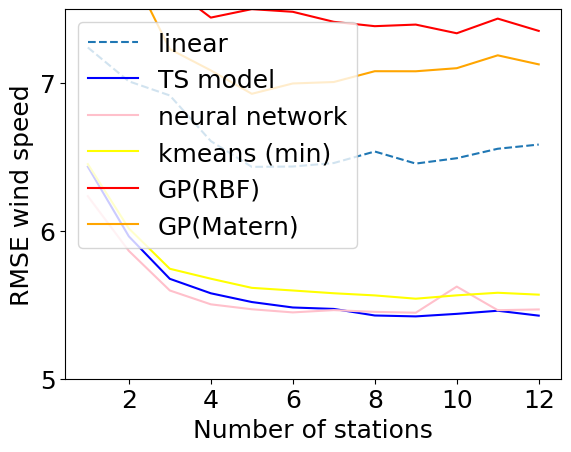

In [26]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []
gpr_matern_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_li_ts_km_nn_full_feature:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))

for exp in gpr_rbf_test_results_full_feature:
    gpr_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))
    
for exp in gpr_matern_test_results:
    gpr_matern_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))
   

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.plot(x_axis, gpr_test_plot, label='GP(RBF)', c='red')
plt.plot(x_axis, gpr_matern_test_plot, label='GP(Matern)', c='orange')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')


exp
7.2407±0.0
6.7804±0.0128
6.235±0.0081
exp
7.0117±0.0
6.7255±0.0
5.8649±0.0073
exp
6.916±0.0
6.1403±0.0276
5.5969±0.0055
exp
6.6074±0.0
6.6074±0.0
5.5032±0.0077
exp
6.4329±0.0
6.4329±0.0
5.4698±0.0053
exp
6.4353±0.0
6.4353±0.0
5.4486±0.0058
exp
6.4589±0.0
6.4589±0.0
5.4641±0.0054
exp
6.5369±0.0
6.5368±0.0
5.4522±0.0037
exp
6.4553±0.0
6.4552±0.0
5.4465±0.0048
exp
6.4915±0.0
6.4915±0.0
5.6232±0.5039
exp
6.5555±0.0001
6.5554±0.0
5.4636±0.0075
exp
6.5839±0.0001
6.5838±0.0
5.4686±0.0078


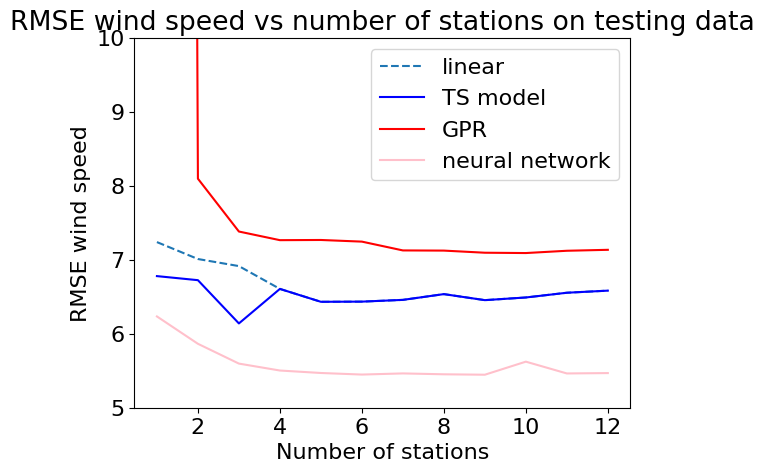

In [28]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in test_results:
    li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
    fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
    nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, gpr_test_plot, label='GPR', c='red')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper right")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")
